Epoch 0, Loss: 0.22214241325855255
Epoch 1000, Loss: 5.481383880123758e-08
Epoch 2000, Loss: 3.1364994356408715e-05
Epoch 3000, Loss: 0.000781155307777226
Epoch 4000, Loss: 7.153399201342836e-05
Epoch 5000, Loss: 5.332473733687948e-07
Epoch 6000, Loss: 1.0757345080492087e-05
Epoch 7000, Loss: 1.5364392424999096e-07
Epoch 8000, Loss: 6.310934708153582e-08
Epoch 9000, Loss: 3.1412287171406206e-07
Epoch 10000, Loss: 3.7900835536675004e-07
Epoch 11000, Loss: 9.83203385374054e-09
Epoch 12000, Loss: 1.9826378775178455e-05
Epoch 13000, Loss: 1.1556596790640583e-09
Epoch 14000, Loss: 5.526668456212747e-09
Epoch 15000, Loss: 2.8774613802795557e-09
Epoch 16000, Loss: 1.025106470819992e-07
Epoch 17000, Loss: 7.567295142507646e-06
Epoch 18000, Loss: 5.196253368922044e-06
Epoch 19000, Loss: 1.999655069084838e-06
Epoch 20000, Loss: 2.4263782094635644e-09
Epoch 21000, Loss: 1.9075572232907234e-09
Epoch 22000, Loss: 4.608562448993325e-06
Epoch 23000, Loss: 5.6458709707385424e-08
Epoch 24000, Loss: 4.1

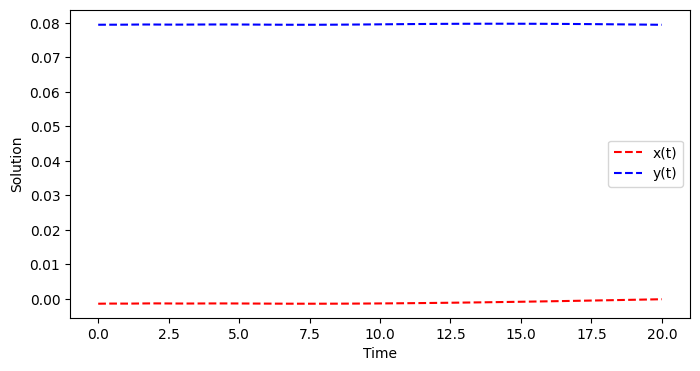

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the Van der Pol equation
def VanDerPol(y, t, epsilon):
    x, y = y
    dxdt = y
    dydt = epsilon * (1 - x**2) * y - x
    return [dxdt, dydt]

# Set the parameters
epsilon = 1/100
t_span = [0, 20]

# Generate boundary conditions
y0 = [2, 0]
y1 = [0, 0]

# Convert to tensor
t_tensor = torch.tensor(t_span, dtype=torch.float32).view(-1, 1)
y0_tensor = torch.tensor(y0, dtype=torch.float32).view(1, -1)
y1_tensor = torch.tensor(y1, dtype=torch.float32).view(1, -1)

# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        self.fc1 = nn.Linear(3, 200)  # Adjusted input size to accommodate (t, x, y)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 2)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Loss function for the PINN
def loss_func(model, t_tensor, y0_tensor, y1_tensor, epsilon):
    t_tensor.requires_grad = True
    t_tensor_0 = torch.cat([t_tensor[0].view(1, 1).repeat(y0_tensor.shape[0], 1), y0_tensor], dim=1)
    t_tensor_1 = torch.cat([t_tensor[1].view(1, 1).repeat(y1_tensor.shape[0], 1), y1_tensor], dim=1)
    
    pred_0 = model(t_tensor_0)
    pred_1 = model(t_tensor_1)

    dx_dt_0 = torch.autograd.grad(pred_0[:, 0].sum(), t_tensor_0, retain_graph=True, create_graph=True)[0][:, 1]
    dy_dt_0 = torch.autograd.grad(pred_0[:, 1].sum(), t_tensor_0, retain_graph=True, create_graph=True)[0][:, 1]

    dx_dt_1 = torch.autograd.grad(pred_1[:, 0].sum(), t_tensor_1, retain_graph=True, create_graph=True)[0][:, 1]
    dy_dt_1 = torch.autograd.grad(pred_1[:, 1].sum(), t_tensor_1, retain_graph=True, create_graph=True)[0][:, 1]

    # Boundary conditions
    bc_loss_0 = torch.mean((dx_dt_0 - y0_tensor[:, 1])**2 + (dy_dt_0 - (epsilon * (1 - pred_0[:, 0]**2) * pred_0[:, 1] - pred_0[:, 0]))**2)
    bc_loss_1 = torch.mean((dx_dt_1 - y1_tensor[:, 1])**2 + (dy_dt_1 - (epsilon * (1 - pred_1[:, 0]**2) * pred_1[:, 1] - pred_1[:, 0]))**2)

    # Volume loss
    t_samples = torch.rand(100, 1) * (t_span[1] - t_span[0]) + t_span[0]
    t_samples.requires_grad = True
    pred_samples = model(torch.cat([t_samples, torch.zeros_like(t_samples), torch.zeros_like(t_samples)], dim=1))

    dx_dt_samples = torch.autograd.grad(pred_samples[:, 0].sum(), t_samples, create_graph=True)[0]
    dy_dt_samples = torch.autograd.grad(pred_samples[:, 1].sum(), t_samples, create_graph=True)[0]

    volume_loss = torch.mean(dx_dt_samples**2 + dy_dt_samples**2)

    # Total loss
    total_loss = bc_loss_0 + bc_loss_1 + 0.1 * volume_loss

    return total_loss

if __name__ == '__main__':
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(50000):
        loss = loss_func(model, t_tensor, y0_tensor, y1_tensor, epsilon)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Model evaluation
    model.eval()
    with torch.no_grad():
        t_samples = torch.linspace(t_span[0], t_span[1], 100).view(-1, 1)
        pred_samples = model(torch.cat([t_samples, torch.zeros_like(t_samples), torch.zeros_like(t_samples)], dim=1))

    # Plot results
    plt.figure(figsize=(8, 4))
    plt.plot(t_samples.numpy(), pred_samples[:, 0].numpy(), 'r--', label='x(t)')
    plt.plot(t_samples.numpy(), pred_samples[:, 1].numpy(), 'b--', label='y(t)')
    plt.xlabel('Time')
    plt.ylabel('Solution')
    plt.legend()
    plt.show()
